In [92]:
# Imports
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import altair as alt
from vega_datasets import data

In [93]:
# Select data
datasets = [
    "../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv",
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv",
]

OECD = True  # False for WB data
if OECD:
    df = pd.read_csv(datasets[0])
    mm_ind = "MATIMATM"
else:
    df = pd.read_csv(datasets[1])
    mm_ind = "SH.STA.MMRT.NE"

In [94]:
# Utility functions


def add_info_to_reduced(reduced, original, labels):
    """Transformed reduced data into a dataframe and adds country and cluster info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["Cluster"] = list(labels)
    reduced["Country"] = list(original["Country"])

    return reduced


def viz_reduction(source, params):
    """Produces 2D chart of reduced data"""

    # Alter scale
    set_scale = [alt.Scale(), alt.Scale()]
    if params["scale"]:
        set_scale = [
            alt.Scale(domain=params["scale"]["x"]),
            alt.Scale(domain=params["scale"]["y"]),
        ]

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle(clip=True)
        .encode(
            x=alt.X("0", title="Component 1", scale=set_scale[0]),
            y=alt.Y("1", title="Component 2", scale=set_scale[1]),
            color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")),
            tooltip=["Country"],
        )
        .configure_axis(grid=False)
        .properties(
            title="{} Visualization of OECD Nations using {} {} Indicators, for {}".format(
                params["method"], params["dataset"], params["theme"], params["year"]
            ),
            width=500,
            height=500,
        )
    )

    return chart

## Data Preparation

In [95]:
# Reduce to only gender indicators

if not OECD:
    gender_ind = pd.read_csv("../WorldBankDatasets/Gender_WorldBankData.csv").columns
    df = df.drop(columns=[col for col in df if col not in gender_ind])

df.head()

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,SRHSTGHE,TOBATBCT_GRPPERQT,TOBATBCT_NBPFUMNB,TOBATBCT_PDLSFMTF,TOBATBCT_PDLSHOTH,TOBATBCT_PDLSTOTX,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI
0,AUS,2010,0.681481,0.438622,0.447901,0.429774,0.356844,0.374339,0.345149,0.415388,...,0.923453,0.392509,0.744186,0.472574,0.296089,0.381974,0.371069,0.281174,0.320442,0.975265
1,AUS,2011,0.666667,0.470645,0.480000,0.461392,0.386473,0.404762,0.375000,0.446931,...,0.902280,0.375896,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
2,AUS,2012,0.651852,0.437652,0.446914,0.428980,0.351691,0.369048,0.339552,0.413043,...,0.900109,0.372779,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
3,AUS,2013,0.644444,0.407569,0.416790,0.398951,0.332367,0.349206,0.320896,0.386189,...,0.900109,0.351000,0.573643,0.354430,0.243017,0.283262,0.333333,0.254279,0.284530,0.975265
4,AUS,2014,0.629630,0.448326,0.457778,0.438990,0.336232,0.354167,0.325560,0.415601,...,0.899023,0.313143,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265


In [96]:
# Select year and drop country
year = 2015
df = df[df["Year"] == year]

# Scale predictor
# scaler = MinMaxScaler()
# df[mm_ind] = scaler.fit_transform(df[mm_ind].to_numpy().reshape(-1, 1))

# Drop year, country, and predictor
X = df.drop(columns=["Country", "Year", mm_ind])

In [97]:
# Set parameters for visualizations
params = {}
params["dataset"] = "OECD" if OECD else "World Bank"
params["theme"] = "Gender" if not OECD else "All"
params["year"] = year
params["scale"] = None

## Dimensionality Reduction with UMAP

In [98]:
embeddings = umap.UMAP(
    n_components=2, n_neighbors=3, min_dist=0.1, random_state=42
).fit_transform(X)

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## K-Means Clustering

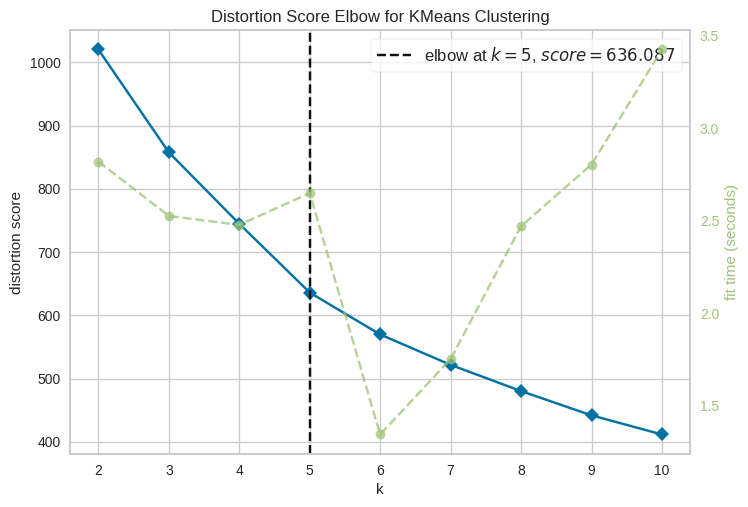

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
# Select number of clusters using "elbow" heuristic
# Evaluate using sklearn's shillouette score metric / higher is better

kmeans = KMeans(n_init=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2, 11))

visualizer.fit(X)
visualizer.show()

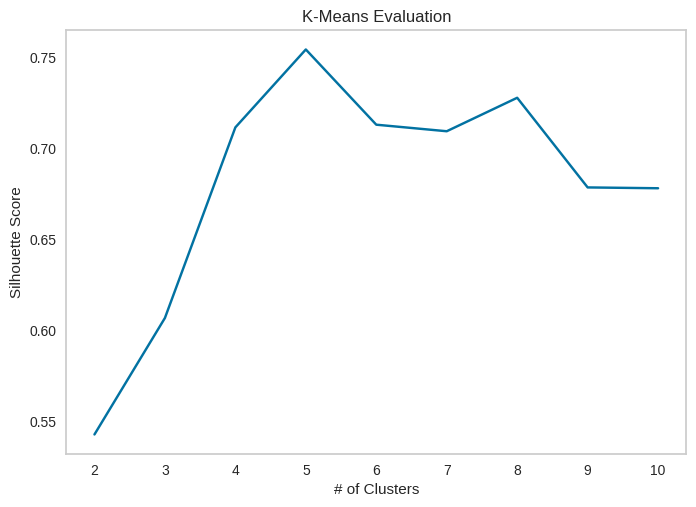

In [100]:
score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans.fit(embeddings)
    score.append(silhouette_score(embeddings, kmeans.labels_))


plt.plot(range(2, 11), score)
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 11))
plt.title("K-Means Evaluation")
plt.grid(False)
plt.show()

In [110]:
kmeans = KMeans(n_clusters=5, n_init=100, random_state=42)
kmeans.fit(embeddings)
silhouette_score(embeddings, kmeans.labels_)

0.7545087

In [111]:
# Visualize the clusters on UMAP projection
kmeans = KMeans(n_clusters=5, n_init=100, random_state=42)
kmeans.fit(X)

params["method"] = "UMAP"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df, kmeans.labels_), params)

alt.Chart(...)

In [112]:
# Produce mapping
# Source: https://gist.github.com/radcliff/f09c0f88344a7fcef373

mapping_name_to_iso = (
    pd.read_csv("../misc/wikipedia-iso-country-codes.csv")
    .set_index("Alpha-3 code")
    .to_dict()["Numeric code"]
)

iso_codes = [mapping_name_to_iso[c] for c in df["Country"].unique()]

In [113]:
# Plot clusters on a world map for visualization purposes
world_data = alt.topo_feature(data.world_110m.url, "countries")
ocean = alt.Chart(alt.sphere()).mark_geoshape(fill="lightblue")

countries = (
    alt.Chart(world_data)
    .mark_geoshape(stroke="black", strokeWidth=0.15)
    .encode(
        color=alt.Color(
            "Cluster:N",
        )
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            pd.DataFrame({"ISO": iso_codes, "Cluster": kmeans.labels_}),
            "ISO",
            ["Cluster"],
        ),
    )
)

world_map = (
    (ocean + countries)
    .project("naturalEarth1")
    .properties(
        width=1000,
        height=500,
        title="Clustering of OECD countries for 2015, using OECD Indicators",
    )
)

world_map

alt.LayerChart(...)

## Alternative Methods - Agglomerative Clustering

In [114]:
agg = AgglomerativeClustering(n_clusters=5)
agg.fit(embeddings)

agg.labels_, silhouette_score(embeddings, agg.labels_)

(array([0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 1, 4, 0, 1, 0, 1, 3, 3, 0, 0, 0,
        1, 1, 1, 4, 0, 4, 2, 4, 0, 0, 0, 3, 1, 3, 1, 3, 3, 0, 2, 0]),
 0.7545087)

In [118]:
# Adding dummy data to match category colors between chart and world map
d_embeddings = np.append(embeddings, [[-99, -99]], axis=0)
d_df = df.copy()
d_df.loc[len(df)] = np.NaN
d_labels_ = np.append(agg.labels_, -1)

params["scale"] = {"x": [0, 18], "y": [0, 18]}
viz_reduction(add_info_to_reduced(d_embeddings, d_df, d_labels_), params)

alt.Chart(...)

In [119]:
world_data = alt.topo_feature(data.world_110m.url, "countries")
ocean = alt.Chart(alt.sphere()).mark_geoshape(fill="lightblue")

countries = (
    alt.Chart(world_data)
    .mark_geoshape(stroke="black", strokeWidth=0.15)
    .encode(color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")))
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            pd.DataFrame({"ISO": iso_codes, "Cluster": agg.labels_}),
            "ISO",
            ["Cluster"],
        ),
    )
)

world_map = (
    (ocean + countries)
    .project("naturalEarth1")
    .properties(
        width=1000,
        height=500,
        title="Clustering of OECD countries for 2015, using OECD Indicators",
    )
)

world_map

alt.LayerChart(...)

## Investigation of Cluster Groups

In [120]:
df['Cluster'] = agg.labels_

df.head()

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,TOBATBCT_GRPPERQT,TOBATBCT_NBPFUMNB,TOBATBCT_PDLSFMTF,TOBATBCT_PDLSHOTH,TOBATBCT_PDLSTOTX,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI,Cluster
5,AUS,2015,0.637037,0.441533,0.450864,0.432316,0.331401,0.349206,0.319963,0.409207,...,0.294972,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265,0
17,AUT,2015,0.740741,0.137312,0.142222,0.132507,0.205797,0.216270,0.201493,0.159847,...,0.591294,0.705426,0.617440,0.439479,0.566524,0.497904,0.468623,0.481584,0.971731,0
29,BEL,2015,0.681481,0.191331,0.196872,0.185891,0.230596,0.243717,0.225124,0.205456,...,0.362966,0.702842,0.528833,0.428305,0.510730,0.433962,0.392828,0.410681,0.939929,0
38,CAN,2015,0.503704,0.093644,0.102222,0.084843,0.080193,0.098214,0.070896,0.090153,...,0.443059,0.643411,0.354430,0.248603,0.287554,0.216981,0.205379,0.209945,0.975265,0
49,CHE,2015,0.570370,0.162542,0.166914,0.158246,0.191304,0.202381,0.187500,0.171995,...,0.569323,0.304910,0.548523,0.393855,0.496423,0.484277,0.422168,0.449355,0.975265,0


In [121]:
df.groupby('Cluster')[mm_ind].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,18.0,4.127778,4.378128,0.0,1.55,3.40,4.650,18.0
1,8.0,5.762500,1.921263,3.4,4.20,5.70,7.150,8.7
2,5.0,29.320000,16.098354,14.6,15.50,27.80,35.000,53.7
3,7.0,5.185714,4.069164,1.6,2.25,5.00,5.900,13.4
4,4.0,16.175000,26.399290,0.0,0.00,4.75,20.925,55.2
